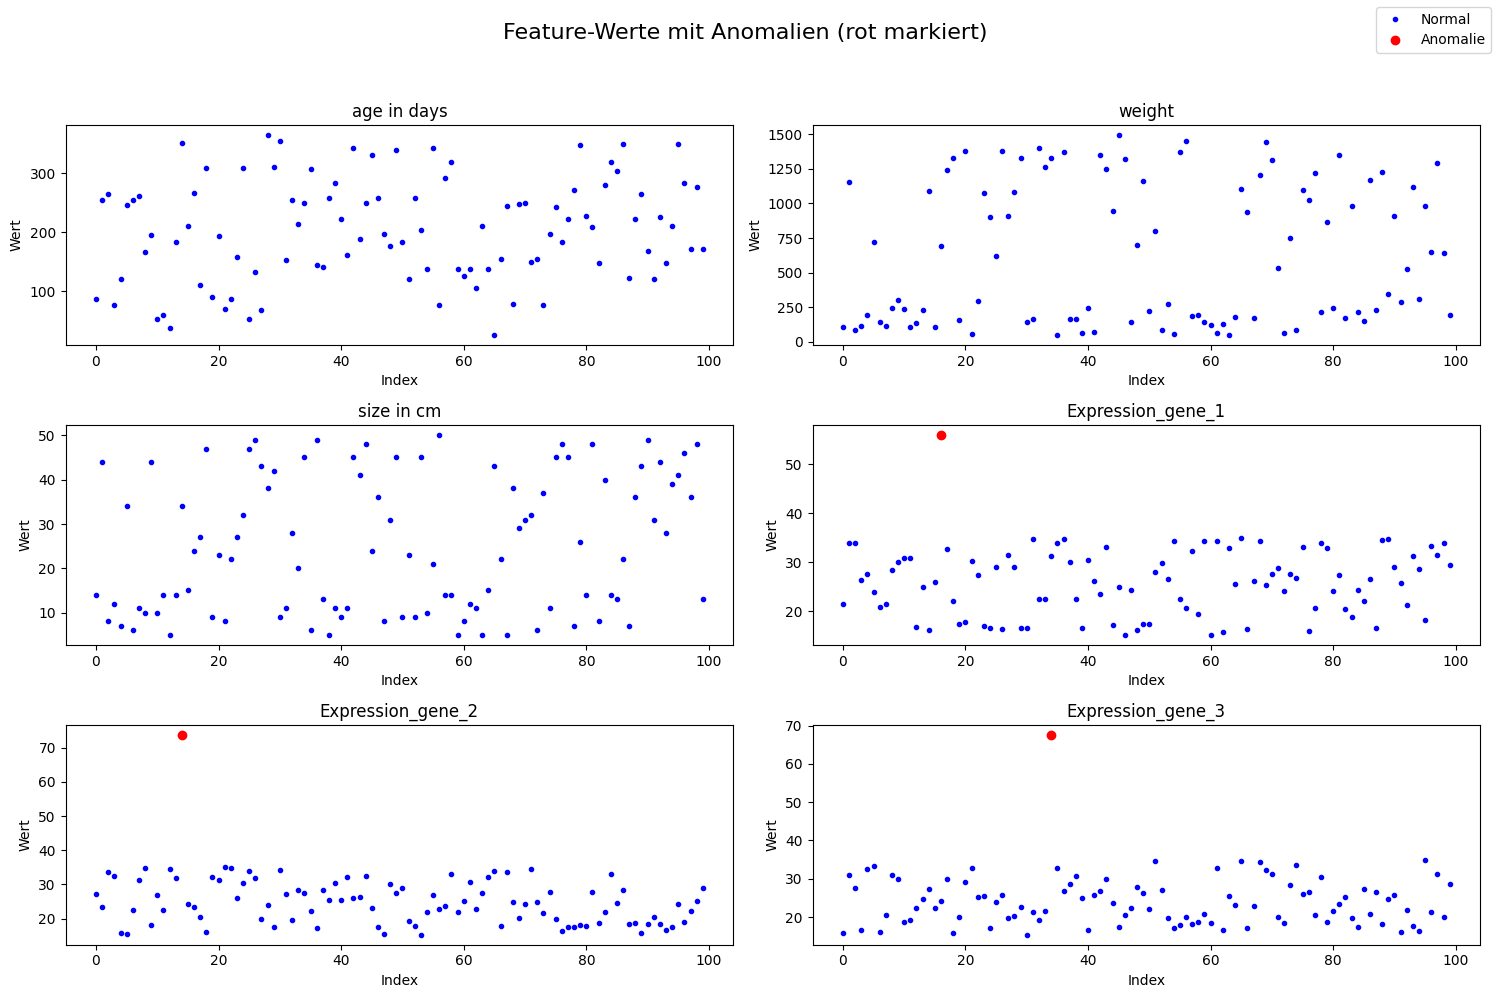

Anomalien wurden erkannt und in anomalies.json gespeichert.
{
    "age in days": [],
    "weight": [],
    "size in cm": [],
    "Expression_gene_1": [
        16
    ],
    "Expression_gene_2": [
        14
    ],
    "Expression_gene_3": [
        34
    ]
}


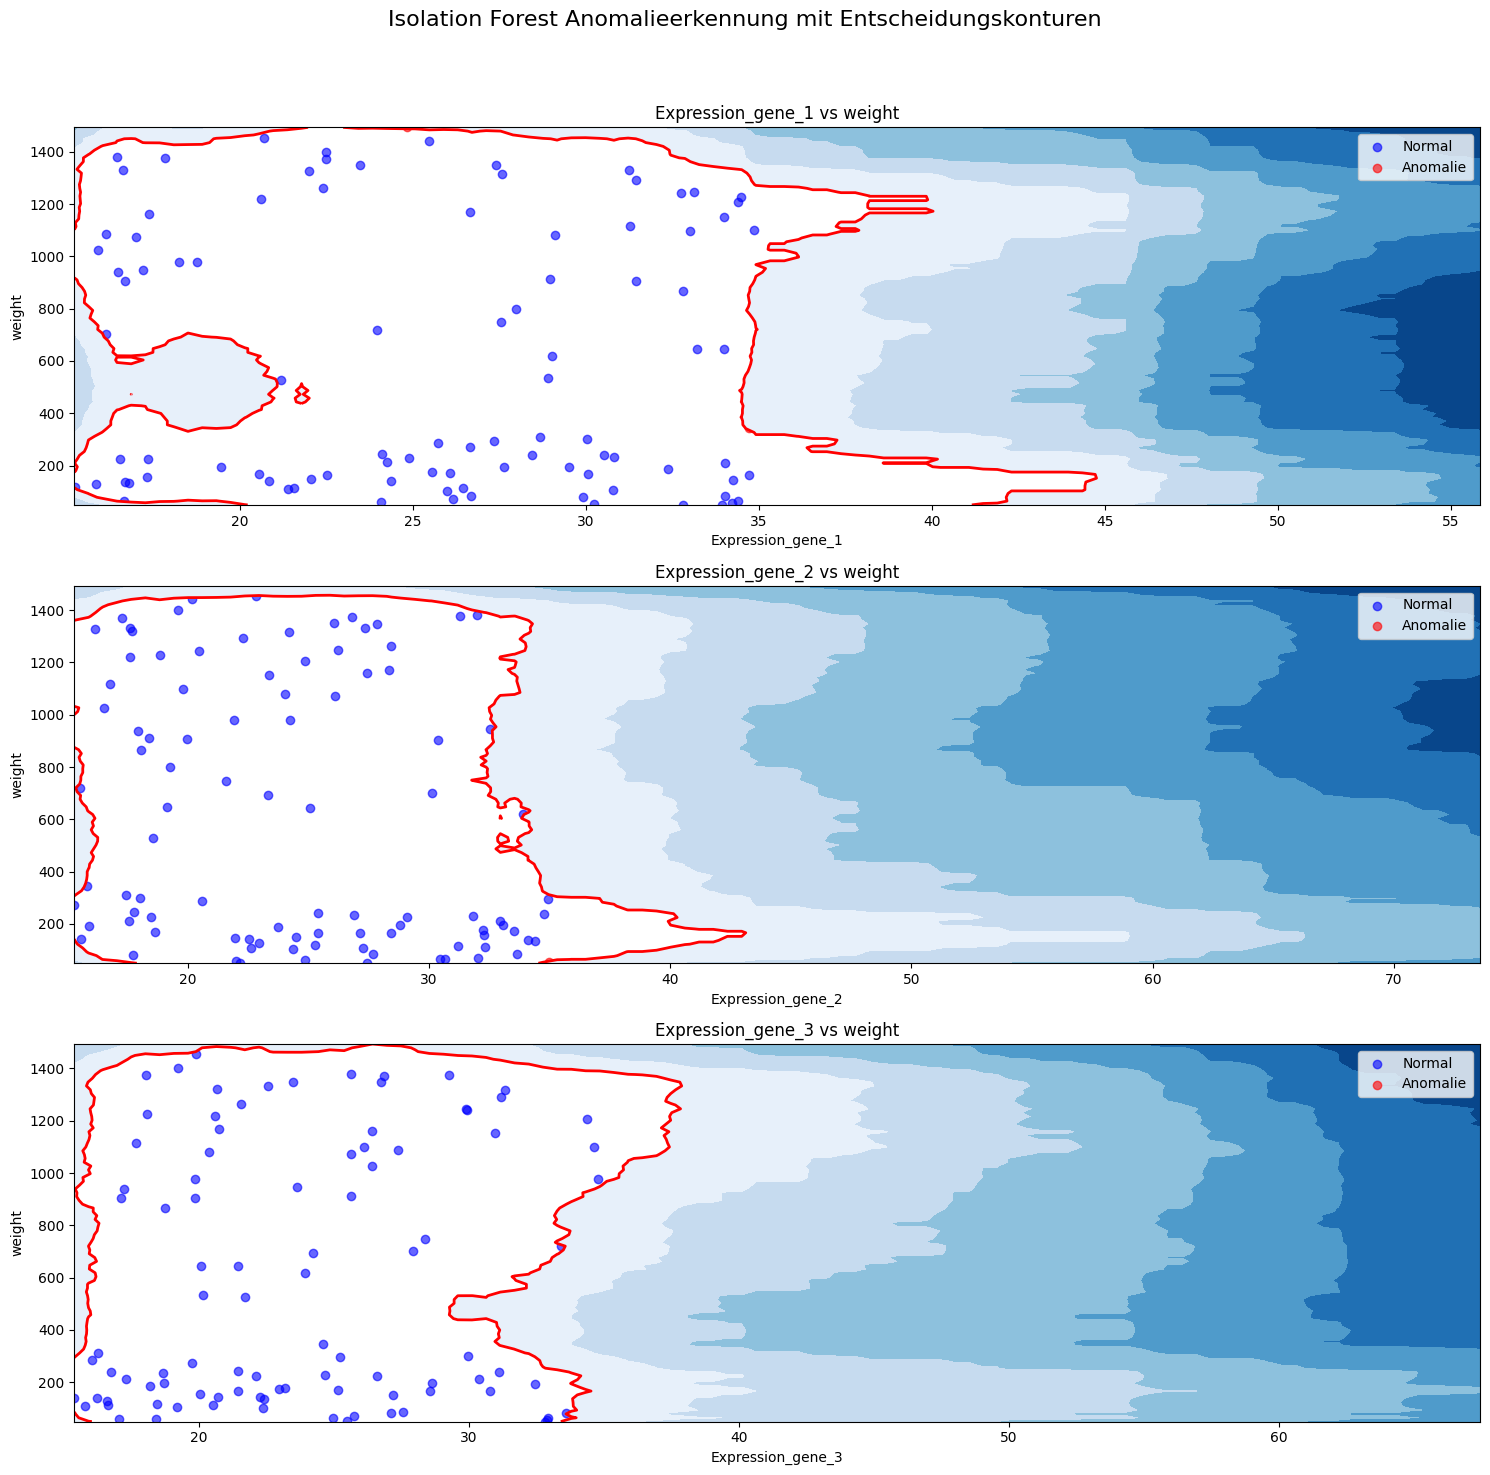

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.ensemble import IsolationForest

# ======================
# 1. CSV-Datei laden
# ======================
# Datei einlesen - Falls die Datei an einem anderen Ort liegt, den Pfad anpassen
file_path = "/users/tobiaswachtel/downloads/Synthetische_biologische_Daten.csv"
df = pd.read_csv(file_path)

# ======================
# 2. Auswahl numerischer Spalten für die Anomalieerkennung
# ======================
numeric_columns = ["age in days", "weight", "size in cm", 
                   "Expression_gene_1", "Expression_gene_2", "Expression_gene_3"]

# Berechnung der Mittelwerte und Standardabweichungen für jede Spalte
means = df[numeric_columns].mean()
stds = df[numeric_columns].std()

# ======================
# 3. Anomalien identifizieren (3-Sigma-Regel)
# ======================
def is_anomaly(series, mean, std, threshold=3):
    """
    Funktion zur Identifikation von Anomalien basierend auf der 3-Sigma-Regel.
    Ein Wert wird als Anomalie betrachtet, wenn er außerhalb von (mean ± threshold * std) liegt.
    """
    return (series < mean - threshold * std) | (series > mean + threshold * std)

# Identifiziere Anomalien für jede numerische Spalte
anomaly_indices = {col: is_anomaly(df[col], means[col], stds[col]) for col in numeric_columns}

# ======================
# 4. Datenvisualisierung mit Anomalien
# ======================
plt.figure(figsize=(15, 10))
plt.suptitle("Feature-Werte mit Anomalien (rot markiert)", fontsize=16)

for i, feature in enumerate(numeric_columns, start=1):
    plt.subplot(3, 2, i)
    plt.plot(df[feature].values, 'b.', label='Normal')
    anomaly_idx = df.index[anomaly_indices[feature]]
    plt.plot(anomaly_idx, df.loc[anomaly_idx, feature], 'ro', label='Anomalie')
    plt.title(feature)
    plt.xlabel('Index')
    plt.ylabel('Wert')

# Legende nur einmal anzeigen
handles, labels = plt.gca().get_legend_handles_labels()
plt.figlegend(handles, labels, loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ======================
# 5. Anomalien als JSON speichern
# ======================
anomaly_dict = {col: df.index[anomaly_indices[col]].tolist() for col in numeric_columns}
json_anomalies = json.dumps(anomaly_dict, indent=4)

# Speichern der Anomalien in einer JSON-Datei
with open("anomalies.json", "w") as json_file:
    json_file.write(json_anomalies)

print("Anomalien wurden erkannt und in anomalies.json gespeichert.")
print(json_anomalies)

# ======================
# 6. Isolation Forest Anomalieerkennung und Visualisierung
# ======================
features = ["Expression_gene_1", "Expression_gene_2", "Expression_gene_3"]
target = "weight"

plt.figure(figsize=(15, 15))
plt.suptitle("Isolation Forest Anomalieerkennung mit Entscheidungskonturen", fontsize=16)

for i, feature in enumerate(features, start=1):
    plt.subplot(3, 1, i)
    
    # Daten für das Modell vorbereiten
    X = df[[feature, target]].values
    
    # Isolation Forest Modell initialisieren und trainieren
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    iso_forest.fit(X)
    df['anomaly'] = iso_forest.predict(X)
    
    # Datenpunkte nach Normal und Anomalie klassifizieren
    normal = df[df['anomaly'] == 1]
    anomalies = df[df['anomaly'] == -1]
    
    # Visualisierung der Datenpunkte
    plt.scatter(normal[feature], normal[target], c='b', label='Normal', alpha=0.6)
    plt.scatter(anomalies[feature], anomalies[target], c='r', label='Anomalie', alpha=0.6)
    
    # Erstellung eines Rasters für Entscheidungskonturen
    xx, yy = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 100),
                         np.linspace(X[:, 1].min(), X[:, 1].max(), 100))
    Z = iso_forest.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Darstellung der Entscheidungskonturen
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.Blues_r)
    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='red')
    
    plt.title(f"{feature} vs {target}")
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()